<a href="https://colab.research.google.com/github/sv650s/sb-capstone2/blob/master/notebooks/6-atp_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ATP Tennis Data - Logistic Regression Using One Hot Encoding

In [4]:
from google.colab import drive
drive.mount('/gdrive')



Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
import json
import sys
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import SGD


import tensorflow as tf


%matplotlib inline
sns.set()

tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
DRIVE_DIR = '/gdrive/My Drive/Springboard/capstone2'
DATASET_DIR = f'{DRIVE_DIR}/datasets'
MODEL_DIR = f'{DRIVE_DIR}/models'

FEATURE_FILE_1985 = f'{DATASET_DIR}/atp_matches_1985-2019_features.csv'
FEATURE_FILE_1998 = f'{DATASET_DIR}/atp_matches_1998-2019_features.csv'


FEATURE_FILE_1985_DIFF = f'{DATASET_DIR}/atp_matches_1985-2019_features-diff.csv'
FEATURE_FILE_1998_DIFF = f'{DATASET_DIR}/atp_matches_1998-2019_features-diff.csv'

FEATURE_FILE_1985_DIFF_OHE = f'{DATASET_DIR}/atp_matches_1985-2019_features-diff-ohe.csv'
FEATURE_FILE_1998_DIFF_OHE = f'{DATASET_DIR}/atp_matches_1998-2019_features-diff-ohe.csv'

LABEL_COL = 'p1_winner'

sys.path.append(DRIVE_DIR)


In [86]:
features_1998_orig = pd.read_csv(FEATURE_FILE_1998)
features_1998_orig.head()

,draw_size,p1,p1_age,p1_hand,p1_ht,p1_ioc,p1_rank,p1_seed,p1_winner,p2,p2_age,p2_hand,p2_ht,p2_ioc,p2_rank,p2_seed,round_label,surface_label,tourney_id_label,tourney_level_label,tourney_month,tourney_year
0,32,102035,25.79,1,183.0,70,4,1,1,101917,26.61,1,188.0,64,74,19,5,3,62,4,1,1998
1,32,101727,27.76,1,185.0,3,79,24,1,102548,22.85,1,175.0,17,87,25,5,3,62,4,1,1998
2,32,102491,23.08,1,185.0,32,71,18,0,102765,21.76,1,185.0,29,93,27,5,3,62,4,1,1998
3,32,101647,28.25,1,175.0,83,76,21,0,102563,22.79,1,180.0,70,39,7,5,3,62,4,1,1998
4,32,102104,25.37,1,188.0,54,65,16,0,102796,21.60,1,188.0,70,22,4,5,3,62,4,1,1998


In [87]:
features_1998 = features_1998_orig
# extra our label column
labels_1998 = features_1998[LABEL_COL]
# one hot encode our labels for Keras
label_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
labels_1998_encoded = label_encoder.fit_transform(features_1998[[LABEL_COL]])
# drop this from our features
features_1998 = features_1998.drop([LABEL_COL], axis=1)

features_1998.head()

,draw_size,p1,p1_age,p1_hand,p1_ht,p1_ioc,p1_rank,p1_seed,p2,p2_age,p2_hand,p2_ht,p2_ioc,p2_rank,p2_seed,round_label,surface_label,tourney_id_label,tourney_level_label,tourney_month,tourney_year
0,32,102035,25.79,1,183.0,70,4,1,101917,26.61,1,188.0,64,74,19,5,3,62,4,1,1998
1,32,101727,27.76,1,185.0,3,79,24,102548,22.85,1,175.0,17,87,25,5,3,62,4,1,1998
2,32,102491,23.08,1,185.0,32,71,18,102765,21.76,1,185.0,29,93,27,5,3,62,4,1,1998
3,32,101647,28.25,1,175.0,83,76,21,102563,22.79,1,180.0,70,39,7,5,3,62,4,1,1998
4,32,102104,25.37,1,188.0,54,65,16,102796,21.60,1,188.0,70,22,4,5,3,62,4,1,1998


In [88]:
labels_1998_encoded[:5]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [0]:
# split into training and test set
X_train_1998, X_test_1998, y_train_1998_encoded, y_test_1998_encoded = train_test_split(features_1998, labels_1998_encoded)
y_test_1998 = label_encoder.inverse_transform(y_test_1998_encoded)

In [43]:
X_train_1998.shape

(43401, 21)

# Implement Neural Network

LR is just a 1 layer dense network with softmax

We should get similar results as our [logistic regression notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/4-atp_logistic_regression.ipynb)

Baseline of our model is 65% accruacy



In [100]:
from keras.models import Sequential 
from keras.layers import Dense, Activation 
from keras import regularizers
import keras as K


output_dim = nb_classes = 2
model_lr_1998 = Sequential() 
model_lr_1998.add(Dense(X_train_1998.shape[1] * 10, 
                   input_shape=(X_train_1998.shape[1], ), 
                   activation='relu', 
                   kernel_initializer=K.initializers.glorot_uniform(seed=1), 
                   kernel_regularizer=regularizers.l2(0.01))) 
model_lr_1998.add(Dropout(0.2))
model_lr_1998.add(Dense(X_train_1998.shape[1] * 10, 
                   activation='relu', 
                   kernel_initializer=K.initializers.glorot_uniform(seed=1), 
                   kernel_regularizer=regularizers.l2(0.01))) 
model_lr_1998.add(Dropout(0.2))
model_lr_1998.add(Dense(output_dim, 
                   activation='softmax', 
                   kernel_initializer=K.initializers.glorot_uniform(seed=1))) 
# model_lr_1998.add(Dropout(0.2))
# model_lr_1998.add(output_dim, 
#                    activation='relu', 
#                    kernel_initializer='random_uniform')) 
batch_size = 32 
epochs = 100

model_lr_1998.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy']) 
model_lr_1998.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 210)               4620      
_________________________________________________________________
dropout_12 (Dropout)         (None, 210)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 210)               44310     
_________________________________________________________________
dropout_13 (Dropout)         (None, 210)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 422       
Total params: 49,352
Trainable params: 49,352
Non-trainable params: 0
_________________________________________________________________


In [101]:
callbacks = [EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1),
             ModelCheckpoint(filepath=f'{MODEL_DIR}/lr.h5', monitor='val_loss', save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.4,patience=2, min_lr=0.00001, mode='auto')]


history_1998 = model_lr_1998.fit(X_train_1998, y_train_1998_encoded, 
                       batch_size=batch_size, 
                       epochs=epochs,
                       verbose=1, 
                       validation_split=0.1,
                       callbacks=callbacks) 

# evalute our model
score_1998 = model_lr_1998.evaluate(X_test_1998, y_test_1998_encoded, verbose=0) 
print('Test score:', score_1998[0]) 
print('Test accuracy:', score_1998[1])

Train on 39060 samples, validate on 4341 samples
Epoch 1/100
39060/39060 [==============================] - 6s 151us/step - loss: 9.9996 - acc: 0.5004 - val_loss: 9.5796 - val_acc: 0.4987
Epoch 2/100
39060/39060 [==============================] - 5s 132us/step - loss: 9.2273 - acc: 0.5006 - val_loss: 8.9829 - val_acc: 0.4987
Epoch 3/100
39060/39060 [==============================] - 5s 131us/step - loss: 8.7551 - acc: 0.5006 - val_loss: 8.6168 - val_acc: 0.4987
Epoch 4/100
39060/39060 [==============================] - 5s 132us/step - loss: 8.4653 - acc: 0.5006 - val_loss: 8.3921 - val_acc: 0.4987
Epoch 5/100
39060/39060 [==============================] - 5s 131us/step - loss: 8.2875 - acc: 0.5006 - val_loss: 8.2543 - val_acc: 0.4987
Epoch 6/100
39060/39060 [==============================] - 5s 132us/step - loss: 8.1785 - acc: 0.5006 - val_loss: 8.1697 - val_acc: 0.4987
Epoch 7/100
39060/39060 [==============================] - 5s 130us/step - loss: 8.1115 - acc: 0.5006 - val_loss: 8.1

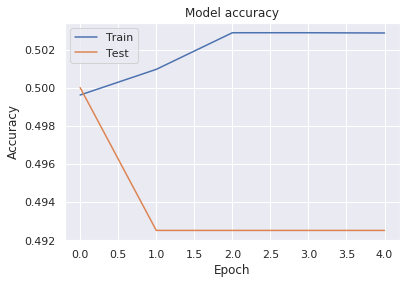

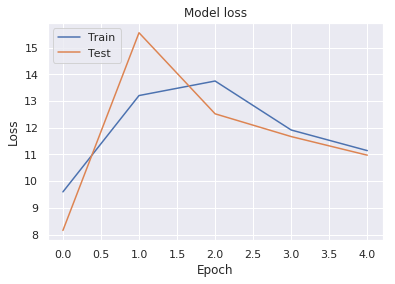

In [93]:
# Plot training & validation accuracy values
plt.plot(history_1998.history['acc'])
plt.plot(history_1998.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_1998.history['loss'])
plt.plot(history_1998.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
# use our model to predict
y_predict_1998_encoded = model_lr_1998.predict(X_test_1998)
# y_predict_1998 = label_encoder.inverse_transform(y_predict_1998_encoded)

In [92]:
y_predict_1998_encoded[:20]

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]], dtype=float32)

In [84]:
y_predict_1998 = [row.idxmax() for index, row in pd.DataFrame(y_predict_1998_encoded).iterrows()]
y_predict_1998[:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [85]:
print(classification_report(y_test_1998, y_predict_1998, target_names=["loss", "win"]))

              precision    recall  f1-score   support

        loss       0.50      1.00      0.66      7201
         win       0.00      0.00      0.00      7266

    accuracy                           0.50     14467
   macro avg       0.25      0.50      0.33     14467
weighted avg       0.25      0.50      0.33     14467



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [63]:
confusion_matrix(y_test_1998, y_predict_1998)

array([[   0, 7277],
       [   0, 7190]])

# Logistic Regression with 1985 to 2019 Dataset

In [0]:
features_1985_diff_ohe_orig = pd.read_csv(FEATURE_FILE_1985_DIFF_OHE)



In [0]:

features_1985_diff_ohe = features_1985_diff_ohe_orig
# extra our label column
labels_1985 = features_1985_diff_ohe[LABEL_COL]
# one hot encode our labels for Keras
label_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
labels_1985_encoded = label_encoder.fit_transform(features_1985_diff_ohe[[LABEL_COL]])
# drop this from our features
features_1985_diff_ohe = features_1985_diff_ohe.drop([LABEL_COL], axis=1)

# split into training and test set
X_train_1985, X_test_1985, y_train_1985_encoded, y_test_1985_encoded = train_test_split(features_1985_diff_ohe, labels_1985_encoded)
y_1985_test = label_encoder.inverse_transform(y_train_encoded)

In [84]:
output_dim = nb_classes = 2
model_lr_1985 = Sequential() 
model_lr_1985.add(Dense(output_dim, 
                   input_dim=X_train.shape[1], 
                   activation='softmax', 
                   kernel_initializer='random_uniform', 
                   kernel_regularizer=regularizers.l2(0.01))) 
model_lr_1985.add(Dropout(0.2))
batch_size = 128 
epochs = 100

model_lr_1985.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) 
model_lr_1985.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
             ModelCheckpoint(filepath=f'{MODEL_DIR}/lr.h5', monitor='val_loss', save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.4,
                              patience=2, 
                              min_lr=0.00001,
                             mode='auto')]


history_1985 = model_lr_1985.fit(X_train_1985, y_train_1985, 
                       batch_size=batch_size, 
                       epochs=epochs,
                       verbose=1, 
                       validation_split=0.1,
                       callbacks=callbacks) 
score_1985 = model_lr_1985.evaluate(X_test_1985, y_test_1985, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 2)                 10504     
_________________________________________________________________
dropout_5 (Dropout)          (None, 2)                 0         
Total params: 10,504
Trainable params: 10,504
Non-trainable params: 0
_________________________________________________________________


NameError: ignored